In [1]:
install.packages("kknn")
library(tidyverse)
library(repr)
library(tidymodels)
library(kknn)
options(repr.matrix.max.rows = 6)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks strin

In [14]:
heart_disease <- read_csv("https://raw.githubusercontent.com/Mikeee12138/Group-Project-dsci100/main/processed.cleveland.data", col_names = FALSE)

colnames(heart_disease) <- c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num")
heart_disease <- heart_disease  |>
filter(ca != "?", thal != "?") |>
mutate(num = as_factor(num), ca = as.numeric(ca))
heart_disease['num'][heart_disease['num'] == '2'] <- '1'
heart_disease['num'][heart_disease['num'] == '3'] <- '1'
heart_disease

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): X12, X13
dbl (12): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3,3.0,1
67,1,4,120,229,0,2,129,1,2.6,2,2,7.0,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
68,1,4,144,193,1,0,141,0,3.4,2,2,7.0,1
57,1,4,130,131,0,0,115,1,1.2,2,1,7.0,1
57,0,2,130,236,0,2,174,0,0.0,2,1,3.0,1


In [15]:
heart_disease_split <- initial_split(heart_disease , prop = 0.75, strata = num) 
heart_disease_train <- training(heart_disease_split)   
heart_disease_test<- testing(heart_disease_split)
heart_disease_train

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<fct>
41,0,2,130,204,0,2,172,0,1.4,1,0,3.0,0
57,0,4,120,354,0,0,163,1,0.6,1,0,3.0,0
57,1,4,140,192,0,0,148,0,0.4,2,0,6.0,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
45,1,1,110,264,0,0,132,0,1.2,2,0,7.0,1
68,1,4,144,193,1,0,141,0,3.4,2,2,7.0,1
57,0,2,130,236,0,2,174,0,0.0,2,1,3.0,1


In [16]:
heart_disease_recipe <- recipe(num ~ age + trestbps + chol , data = heart_disease_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors()) # No Answer - remove if you provide an answer
heart_disease_recipe

Recipe

Inputs:

      role #variables
   outcome          1
 predictor          3

Operations:

Scaling for all_predictors()
Centering for all_predictors()

! Fold1: internal:
  There were 20 warnings in `dplyr::summarise()`.
  The first warning was:
  ℹ In argument: `.estimate = metric_fn(...)`.
  ℹ In group 1: `neighbors = 1`.
  Caused by warning:
  ! No observations were detected in `truth` for level(s): '2', '3'
  Computation will proceed by ignoring those levels.
  ℹ Run `dplyr::last_dplyr_warnings()` to see the 19 ...

! Fold2: internal:
  There were 20 warnings in `dplyr::summarise()`.
  The first warning was:
  ℹ In argument: `.estimate = metric_fn(...)`.
  ℹ In group 1: `neighbors = 1`.
  Caused by warning:
  ! No observations were detected in `truth` for level(s): '2', '3'
  Computation will proceed by ignoring those levels.
  ℹ Run `dplyr::last_dplyr_warnings()` to see the 19 ...

! Fold3: internal:
  There were 20 warnings in `dplyr::summarise()`.
  The first warning was:
  ℹ In argument: `.estimate = metric_fn(...)`.
  ℹ In group 1: `neighbors = 1`.
  Caused by warning:
  ! No observations were detected in `truth` for level(s)

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.4686892,5,0.012679662,Preprocessor1_Model01
2,accuracy,multiclass,0.4686892,5,0.012679662,Preprocessor1_Model02
3,accuracy,multiclass,0.5448555,5,0.009798527,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
18,accuracy,multiclass,0.5855673,5,0.015003724,Preprocessor1_Model18
19,accuracy,multiclass,0.5854663,5,0.009668919,Preprocessor1_Model19
20,accuracy,multiclass,0.5899107,5,0.009805891,Preprocessor1_Model20


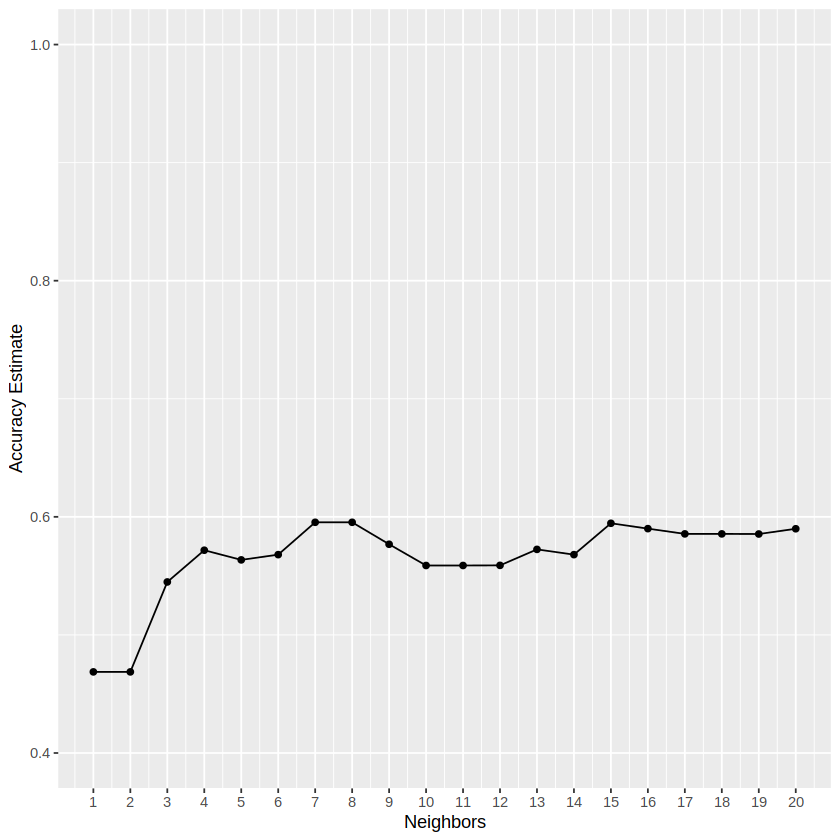

In [17]:
heart_disease_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
       set_engine("kknn") |>
       set_mode("classification")

heart_disease_vfold <- vfold_cv(heart_disease_train, v = 5, strata = num)

k_vals <- tibble(neighbors = seq(from = 1, to = 20, by = 1))

knn_results <- workflow() |>
      add_recipe(heart_disease_recipe) |>
       add_model(heart_disease_spec) |>
       tune_grid(resamples = heart_disease_vfold, grid = k_vals) |>
       collect_metrics()

accuracies <- knn_results |> 
       filter(.metric == "accuracy")
accuracies

max_accuracies <- summarize(accuracies, accuracy = max(mean))
accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
       geom_point() +
       geom_line() +
       labs(x = "Neighbors", y = "Accuracy Estimate") +
       scale_x_continuous(breaks = seq(1, 20, by = 1)) +  
       scale_y_continuous(limits = c(0.4, 1.0)) 
accuracy_versus_k

Recipe

Inputs:

      role #variables
   outcome          1
 predictor          2

Operations:

Scaling for all_predictors()
Centering for all_predictors()

! Fold1: internal:
  There were 20 warnings in `dplyr::summarise()`.
  The first warning was:
  ℹ In argument: `.estimate = metric_fn(...)`.
  ℹ In group 1: `neighbors = 1`.
  Caused by warning:
  ! No observations were detected in `truth` for level(s): '2', '3'
  Computation will proceed by ignoring those levels.
  ℹ Run `dplyr::last_dplyr_warnings()` to see the 19 ...

! Fold2: internal:
  There were 20 warnings in `dplyr::summarise()`.
  The first warning was:
  ℹ In argument: `.estimate = metric_fn(...)`.
  ℹ In group 1: `neighbors = 1`.
  Caused by warning:
  ! No observations were detected in `truth` for level(s): '2'...
  Computation will proceed by ignoring those levels.
  ℹ Run `dplyr::last_dplyr_warnings()` to see the 19 ...

! Fold3: internal:
  There were 20 warnings in `dplyr::summarise()`.
  The first warning was:
  ℹ In argument: `.estimate = metric_fn(...)`.
  ℹ In group 1: `neighbors = 1`.
  Caused by warning:
  ! No observations were detected in `truth` for level(s): 

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.6181254,5,0.02895938,Preprocessor1_Model01
2,accuracy,multiclass,0.6224642,5,0.02866597,Preprocessor1_Model02
3,accuracy,multiclass,0.6757975,5,0.01588467,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
18,accuracy,multiclass,0.7340897,5,0.01370472,Preprocessor1_Model18
19,accuracy,multiclass,0.7293376,5,0.02006873,Preprocessor1_Model19
20,accuracy,multiclass,0.7293376,5,0.02006873,Preprocessor1_Model20


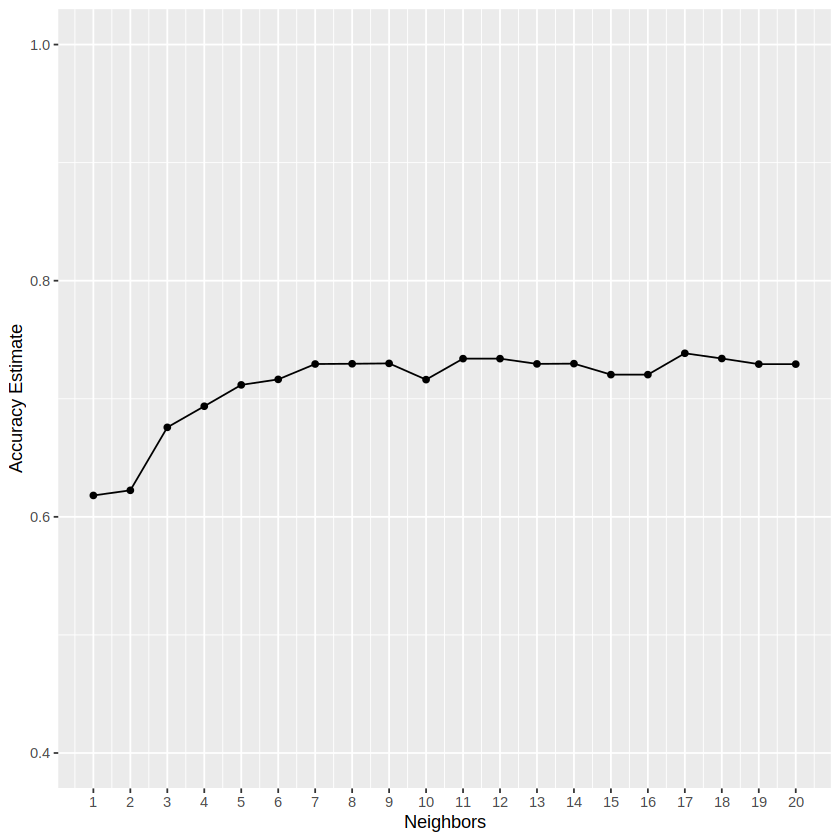

In [18]:
heart_disease_recipe <- recipe(num ~ thalach + oldpeak  , data = heart_disease_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors()) 
heart_disease_recipe

heart_disease_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
       set_engine("kknn") |>
       set_mode("classification")

heart_disease_vfold <- vfold_cv(heart_disease_train, v = 5, strata = num)

k_vals <- tibble(neighbors = seq(from = 1, to = 20, by = 1))

knn_results <- workflow() |>
      add_recipe(heart_disease_recipe) |>
       add_model(heart_disease_spec) |>
       tune_grid(resamples = heart_disease_vfold, grid = k_vals) |>
       collect_metrics()

accuracies <- knn_results |> 
       filter(.metric == "accuracy")
accuracies

max_accuracies <- summarize(accuracies, accuracy = max(mean))
accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
       geom_point() +
       geom_line() +
       labs(x = "Neighbors", y = "Accuracy Estimate") +
       scale_x_continuous(breaks = seq(1, 20, by = 1)) + 
       scale_y_continuous(limits = c(0.4, 1.0)) 
accuracy_versus_k

Recipe

Inputs:

      role #variables
   outcome          1
 predictor          1

Operations:

Scaling for all_predictors()
Centering for all_predictors()

! Fold1: internal:
  There were 20 warnings in `dplyr::summarise()`.
  The first warning was:
  ℹ In argument: `.estimate = metric_fn(...)`.
  ℹ In group 1: `neighbors = 1`.
  Caused by warning:
  ! No observations were detected in `truth` for level(s): '2', '3'
  Computation will proceed by ignoring those levels.
  ℹ Run `dplyr::last_dplyr_warnings()` to see the 19 ...

! Fold2: internal:
  There were 20 warnings in `dplyr::summarise()`.
  The first warning was:
  ℹ In argument: `.estimate = metric_fn(...)`.
  ℹ In group 1: `neighbors = 1`.
  Caused by warning:
  ! No observations were detected in `truth` for level(s): '2', '3'
  Computation will proceed by ignoring those levels.
  ℹ Run `dplyr::last_dplyr_warnings()` to see the 19 ...

! Fold3: internal:
  There were 20 warnings in `dplyr::summarise()`.
  The first warning was:
  ℹ In argument: `.estimate = metric_fn(...)`.
  ℹ In group 1: `neighbors = 1`.
  Caused by warning:
  ! No observations were detected in `truth` for level(s)

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.5543646,5,0.01409753,Preprocessor1_Model01
2,accuracy,multiclass,0.5499201,5,0.01469173,Preprocessor1_Model02
3,accuracy,multiclass,0.5495067,5,0.01390035,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
18,accuracy,multiclass,0.653782,5,0.02072632,Preprocessor1_Model18
19,accuracy,multiclass,0.653782,5,0.02072632,Preprocessor1_Model19
20,accuracy,multiclass,0.653782,5,0.02072632,Preprocessor1_Model20


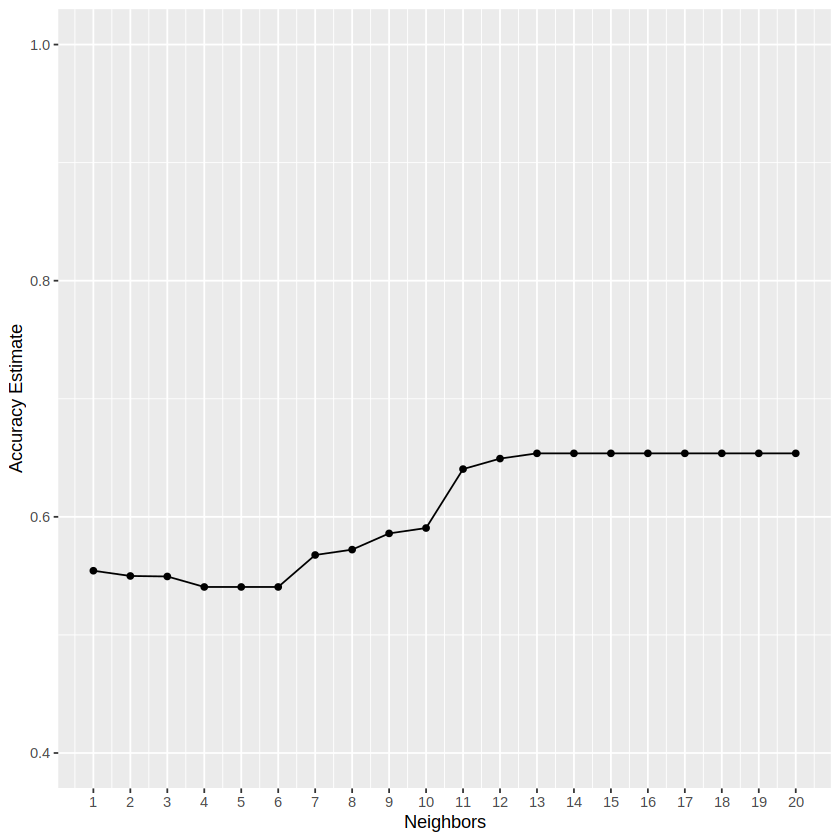

In [19]:
heart_disease_recipe <- recipe(num ~ ca , data = heart_disease_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors()) 
heart_disease_recipe

heart_disease_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
       set_engine("kknn") |>
       set_mode("classification")

heart_disease_vfold <- vfold_cv(heart_disease_train, v = 5, strata = num)

k_vals <- tibble(neighbors = seq(from = 1, to = 20, by = 1))

knn_results <- workflow() |>
      add_recipe(heart_disease_recipe) |>
       add_model(heart_disease_spec) |>
       tune_grid(resamples = heart_disease_vfold, grid = k_vals) |>
       collect_metrics()

accuracies <- knn_results |> 
       filter(.metric == "accuracy")
accuracies

max_accuracies <- summarize(accuracies, accuracy = max(mean))
accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
       geom_point() +
       geom_line() +
       labs(x = "Neighbors", y = "Accuracy Estimate") +
       scale_x_continuous(breaks = seq(1, 20, by = 1)) + 
       scale_y_continuous(limits = c(0.4, 1.0)) 
accuracy_versus_k